status: Draft

# Introduction

This notebook contains exploratory analysis of the power profiles on these grids.

# Method

I'm using the kVA fields but need to better understand how they are calculated.


# Results

The CDFs show three distinct power levels on the grids.  I expect day and night, but I'm not sure about the third.  

One of the grids shows a sharper decline in power use in the early morning.

The microgrids appear to only show one broad power level range.

There are some jumps in the power levels on the minigrids at the start and end of the service period that don't appear real.

# Next Work

- Calculate the load factor for each of these
- Plot load duration curves 
- Compare the microgrid peak and average load to the generator specs and estimate efficiency.
- Add generator questions to our question list
- Create a zero-inserted kVA data set during power outages indicated by message file


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import WP19_analysis as wpa

Here are the CDFs for the kVA reports with nulls removed.

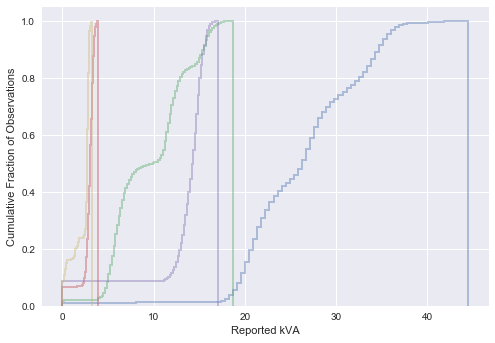

In [3]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    messages = wpa.load_message_file(vname + '-messages.csv')
    sns.distplot(energy_data['kVA sliding window Demand'].dropna(), 
                 hist_kws={'cumulative':True,
                           'histtype':'step',
                           'linewidth':2},
                kde=False,
                norm_hist=True,
                bins=100,
                ax=ax)
ax.set_xlabel('Reported kVA')
ax.set_ylabel('Cumulative Fraction of Observations')

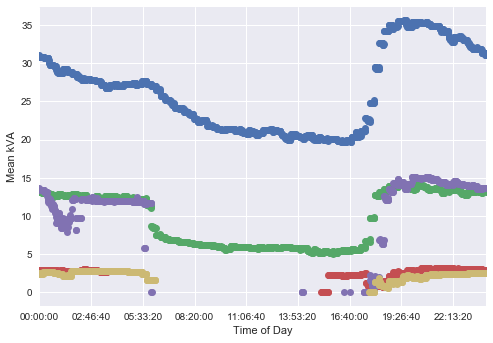

In [13]:
def wpa_averaged_power_profile(energy_data):
    # create power column from current and voltage or use existing kVA fields?
    # print(energy_data.columns)
    # group by and aggregate by time
    # return series with averaged 24 hour power profile
    kVA = energy_data['kVA sliding window Demand']
    return kVA.groupby(kVA.index.time).mean()
    
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    messages = wpa.load_message_file(vname + '-messages.csv')
    wpa_averaged_power_profile(energy_data).plot(marker='o', linestyle='')
    
ax.set_xlabel('Time of Day')
ax.set_ylabel('Mean kVA')
plt.savefig('../plots/hourly_kVA.png')

In [16]:
for rfd in wpa.raw_file_data:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand']
    print(vname, kVA.mean(), kVA.max(), kVA.mean()/kVA.max())


ajau 26.3884025423 44.484 0.593211099323
asei 9.58083455959 18.666 0.513277325597
atamali 2.85609768932 3.884 0.735349559558
ayapo 13.0752589277 17.041 0.767282373554
kensio 2.24596105872 3.253 0.690427623337


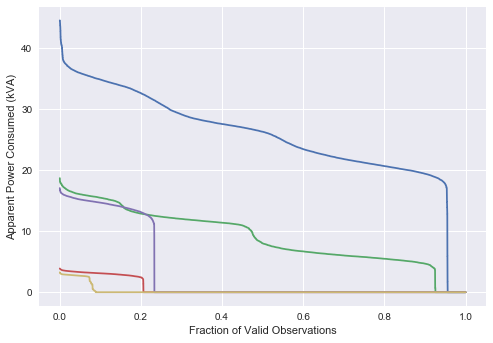

In [8]:
# load duration curve

# FIXME: we need to use a zero-filled data set

def insert_power_gap_zeros(energy_data, messages):
    # this puts zeros in the recorded power gaps and leaves data gaps untouched
    power_down = messages[messages['message']=='Power Down'].index.values
    power_up = messages[messages['message']=='Power Up'].index.values
    # this is diffing all columns and possibly slowing down function
    diffed = energy_data[['kWh export']].resample('1T').asfreq().diff().shift(-1)
    for i in diffed.index.values:
        # if either boundary of the interval is in a power gap, we want to insert a zero
        # if the insertion point of the index is one greater for the power_down time, you are in a gap
        if np.searchsorted(power_down, i) == np.searchsorted(power_up, i) + 1:
            diffed.loc[i]['kWh export'] = 0
        end_interval = i + np.timedelta64(1,'m')
        if np.searchsorted(power_down, end_interval) == np.searchsorted(power_up, end_interval) + 1:
            diffed.loc[i]['kWh export'] = 0
    return diffed['kWh export']

def wpa_insert_zeros_kVA(energy_data, message_data):
    power_down = messages[messages['message']=='Power Down'].index.values
    power_up = messages[messages['message']=='Power Up'].index.values
    energy_data_rs = energy_data.resample('1T').asfreq()
    for i in energy_data_rs.index.values:
        if np.searchsorted(power_down, i) == np.searchsorted(power_up, i) + 1:
            energy_data_rs.loc[i]['kVA sliding window Demand'] = 0
    return energy_data_rs
    
    
def wpa_load_duration_curve(energy_data):
    # sort and order from largest to smallest
    # x-axis should be percent of time but we'll do raw first
    data = energy_data['kVA sliding window Demand'].sort_values(ascending=False).dropna().values
    index = np.linspace(0, 1, len(data))
    return pd.Series(index=index, data=data)

vname = 'ajau'
vname = 'asei'
vname = 'ayapo'
vname = 'kensio'
vname = 'atamali'

fig, ax = plt.subplots()
for rfd in wpa.raw_file_data:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    messages = wpa.load_message_file(vname + '-messages.csv')
    energy_data_zf = wpa_insert_zeros_kVA(energy_data, messages)
    plt.plot(wpa_load_duration_curve(energy_data_zf))

ax.set_xlabel('Fraction of Valid Observations')
ax.set_ylabel('Apparent Power Consumed (kVA)')
plt.savefig('../plots/load_duration_curve.png')